In [1]:
from transformers import BertModel, BertTokenizer
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained("./bert")
model = BertModel.from_pretrained("./bert").to(device)
def bert_embedding(text):
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    return output.last_hidden_state.cpu().detach()

In [2]:
import pandas


train_pd = pandas.read_csv("./data/train.csv")
test_pd = pandas.read_csv("./data/test.csv")
train_X_pos, train_X_neg = [], []
test_X = []
for i in range(train_pd.shape[0]):
    line = train_pd.iloc[i]
    bert_output = bert_embedding(line["text"])
    if line["target"] == 1:
        train_X_pos.append(bert_output)
    elif line["target"] == 0:
        train_X_neg.append(bert_output)
for i in range(test_pd.shape[0]):
    line = test_pd.iloc[i]
    bert_output = bert_embedding(line["text"])
    test_X.append(bert_output)

In [6]:
import torch


class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bilstm = torch.nn.LSTM(768, 16, batch_first=True, bidirectional=True)
        self.attention = torch.nn.MultiheadAttention(32, 1, batch_first=True)
        self.fc = torch.nn.Linear(32, 2)

    def forward(self, x):
        x, _ = self.bilstm(x)
        x, _ = self.attention(x, x, x)
        x = x[:, 0, :]
        x = self.fc(x)
        return x

In [4]:
import random


def align(X, max_length=32):
    if X.shape[0] < max_length:
        X = torch.concat([X, torch.zeros((max_length - X.shape[0], X.shape[1]))], dim=0)
    return X[:max_length, :]

random.seed(1)
select = [(align(X[0]), 1) for X in train_X_pos] + [(align(X[0]), 0) for X in train_X_neg]
random.shuffle(select)
train_set = select[:]
val_set = select[int(0.9 * len(select)):]
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

In [7]:
decoder = Decoder().to(device)
epochs = 50
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss().to(device)
train_acc=[]
val_acc = []
for epoch in range(epochs):
    decoder.train()
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        output = decoder(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    decoder.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            output = torch.argmax(decoder(data), dim=1)
            correct += torch.sum(output == label)
            total += data.size(0)

    train_acc.append(correct / total)
    print(f"epoch: {epoch}, train acc: {correct / total}")
    correct, total = 0, 0
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            output = torch.argmax(decoder(data), dim=1)
            correct += torch.sum(output == label)
            total += data.size(0)
    val_acc.append(correct / total)
    print(f"epoch: {epoch}, val acc: {correct / total}")

epoch: 0, train acc: 0.6985419392585754
epoch: 0, val acc: 0.7099737524986267
epoch: 1, train acc: 0.7458295226097107
epoch: 1, val acc: 0.7532808184623718
epoch: 2, train acc: 0.7661893963813782
epoch: 2, val acc: 0.7716535329818726
epoch: 3, train acc: 0.7843163013458252
epoch: 3, val acc: 0.7860892415046692
epoch: 4, train acc: 0.7940365076065063
epoch: 4, val acc: 0.7979002594947815
epoch: 5, train acc: 0.8049389123916626
epoch: 5, val acc: 0.7979002594947815
epoch: 6, train acc: 0.8122947812080383
epoch: 6, val acc: 0.8070865869522095
epoch: 7, train acc: 0.8178116083145142
epoch: 7, val acc: 0.8070865869522095
epoch: 8, train acc: 0.8218836188316345
epoch: 8, val acc: 0.8110235929489136
epoch: 9, train acc: 0.82490473985672
epoch: 9, val acc: 0.8136482834815979
epoch: 10, train acc: 0.8291081190109253
epoch: 10, val acc: 0.8188976645469666
epoch: 11, train acc: 0.8334428071975708
epoch: 11, val acc: 0.8254593014717102
epoch: 12, train acc: 0.8367266654968262
epoch: 12, val acc: 0

In [ ]:
epochs2 = range(1, 50 + 1)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(epochs2, train_acc, 'bo-', label='Train Acccuracy')
plt.plot(epochs2, val_acc, 'ro-', label='Validation Acccuracy')
plt.title('Training and Validation Acccuracy')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()


plt.tight_layout()
plt.show()


In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score


y_pred = torch.zeros(0)
y_true = torch.zeros(0)
decoder.eval()
with torch.no_grad():
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        output = torch.argmax(decoder(data), dim=1)
        y_pred = torch.concat((y_pred, output.cpu()))
        y_true = torch.concat((y_true, label.cpu()))
print(f"train precision: {precision_score(y_true, y_pred)}")
print(f"train recall: {recall_score(y_true, y_pred)}")
print(f"train f1: {f1_score(y_true, y_pred)}")
y_pred = torch.zeros(0)
y_true = torch.zeros(0)
decoder.eval()
with torch.no_grad():
    for data, label in val_loader:
        data, label = data.to(device), label.to(device)
        output = torch.argmax(decoder(data), dim=1)
        y_pred = torch.concat((y_pred, output.cpu()))
        y_true = torch.concat((y_true, label.cpu()))
print(f"val precision: {precision_score(y_true, y_pred)}")
print(f"val recall: {recall_score(y_true, y_pred)}")
print(f"val f1: {f1_score(y_true, y_pred)}")

train precision: 0.98698153194066
train recall: 0.996637114032406
train f1: 0.9917858229388499
val precision: 0.9910979228486647
val recall: 1.0
val f1: 0.9955290611028316


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

train_precision = []
train_recall = []
train_f1 = []
val_precision = []
val_recall = []
val_f1 = []

for epoch in range(epochs):
    # 训练模型
    decoder.train()
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        output = decoder(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 在训练集上评估模型
    y_pred = torch.tensor([], dtype=torch.long)
    y_true = torch.tensor([], dtype=torch.long)
    decoder.eval()
    with torch.no_grad():
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            output = torch.argmax(decoder(data), dim=1)
            y_pred = torch.cat((y_pred, output.cpu()))
            y_true = torch.cat((y_true, label.cpu()))

    train_precision.append(precision_score(y_true, y_pred, average='macro'))
    train_recall.append(recall_score(y_true, y_pred, average='macro'))
    train_f1.append(f1_score(y_true, y_pred, average='macro'))

    # 在验证集上评估模型
    y_pred = torch.tensor([], dtype=torch.long)
    y_true = torch.tensor([], dtype=torch.long)
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            output = torch.argmax(decoder(data), dim=1)
            y_pred = torch.cat((y_pred, output.cpu()))
            y_true = torch.cat((y_true, label.cpu()))

    val_precision.append(precision_score(y_true, y_pred, average='macro'))
    val_recall.append(recall_score(y_true, y_pred, average='macro'))
    val_f1.append(f1_score(y_true, y_pred, average='macro'))

    # 打印当前 epoch 的评估结果
    print(f"Epoch {epoch}: Train Precision: {train_precision[-1]}, Train Recall: {train_recall[-1]}, Train F1: {train_f1[-1]}")
    print(f"Epoch {epoch}: Val Precision: {val_precision[-1]}, Val Recall: {val_recall[-1]}, Val F1: {val_f1[-1]}")


Epoch 0: Train Precision: 0.9950980267743246, Train Recall: 0.9944532659394895, Train F1: 0.9947703725427254
Epoch 0: Val Precision: 0.9976744186046511, Val Recall: 0.9970059880239521, Val F1: 0.9973329973329974
Epoch 1: Train Precision: 0.9920970062217411, Train Recall: 0.9932140633719744, Train F1: 0.992638129336735
Epoch 1: Val Precision: 0.9946695394258213, Val Recall: 0.9946695394258213, Val F1: 0.9946695394258213
Epoch 2: Train Precision: 0.9949945093648959, Train Recall: 0.9953642910543234, Train F1: 0.9951775800865033
Epoch 2: Val Precision: 0.9958439651857807, Val Recall: 0.9961665454138453, Val F1: 0.99600346156872
Epoch 3: Train Precision: 0.9949047335650747, Train Recall: 0.9946417866709963, Train F1: 0.9947723669500597
Epoch 3: Val Precision: 0.9973347697129107, Val Recall: 0.9973347697129107, Val F1: 0.9973347697129107
Epoch 4: Train Precision: 0.9943717320432859, Train Recall: 0.9943717320432859, Train F1: 0.9943717320432859
Epoch 4: Val Precision: 0.9961674961674962, Va

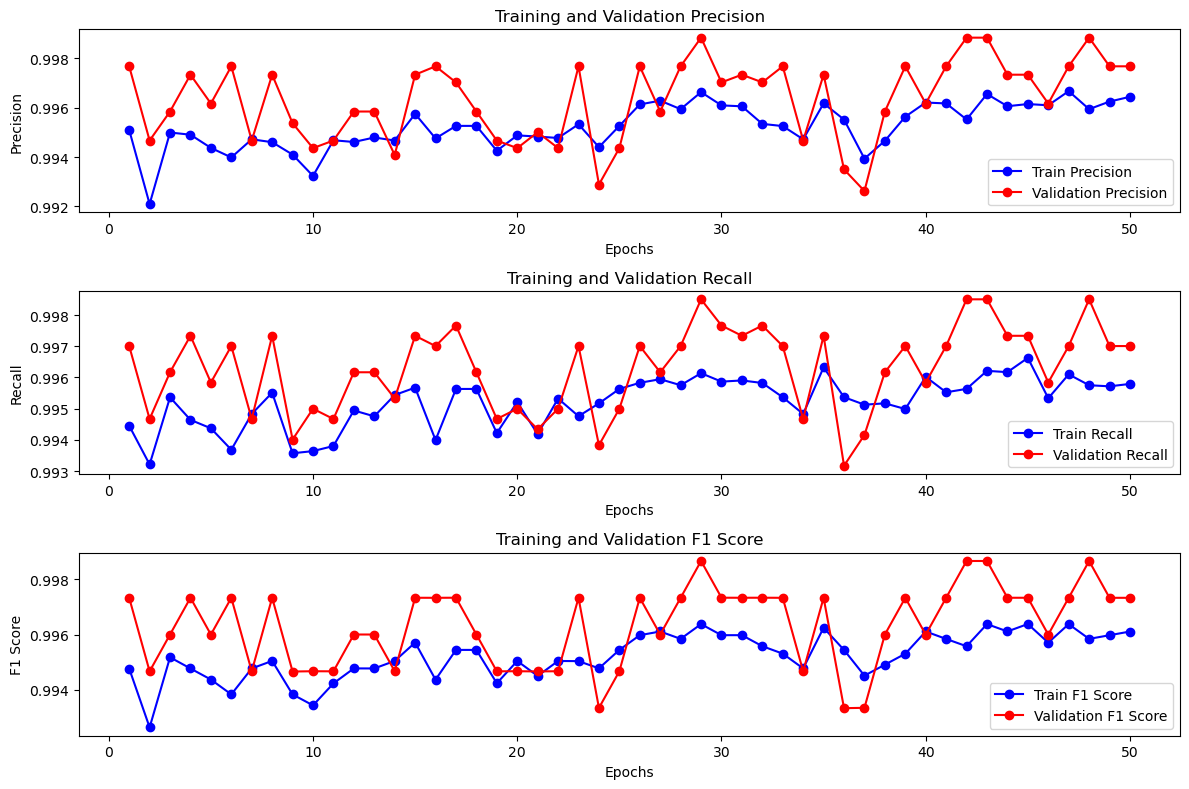

In [21]:


epochs = range(1, 50 + 1)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(epochs, train_precision, 'bo-', label='Train Precision')
plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(epochs, train_recall, 'bo-', label='Train Recall')
plt.plot(epochs, val_recall, 'ro-', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(epochs, train_f1, 'bo-', label='Train F1 Score')
plt.plot(epochs, val_f1, 'ro-', label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


Predict on the test set.

In [ ]:
output_pd = pandas.DataFrame(test_pd["id"])
test_pred = []
for i in range(len(test_X)):
    data = test_X[i].to(device)
    pred = int(torch.argmax(decoder(data), dim=1))
    test_pred.append(pred)
output_pd["target"] = test_pred
output_pd.to_csv("./data/submission.csv", index=False)